# 练习1 哨兵-2号数据获取及处理

##### 哨兵-2号卫星携带一枚多光谱成像仪(MSI)，高度为786km，可覆盖13个光谱波段，幅宽达290千米。地面分辨率分别为10m、20m和60m、一颗卫星的重访周期为10天，两颗互补，重访周期为5天。从可见光和近红外到短波红外，具有不同的空间分辨率，在光学数据中，哨兵-2号数据是唯一一个在红边范围含有三个波段的数据，这对监测植被健康信息非常有效。
##### 蓝色 (B2)、绿色 (B3)、红色 (B4) 和近红外 (B8) 波段具有 10 米的分辨率；红端（B5）、近红外 NIR（B6、B7 和 B8A）以及短波红外 SWIR（B11和B12）的地面采样距离为20米；沿海大气气溶胶 (B1) 和卷云波段 (B10) 的像素大小为 60 米；


![](https://www.osgeo.cn/static/upload/2f/2f0966ba-f36f-11ec-ba59-00163e056ce7_m.jpg)

环境要求： 
* GDAL==2.4.1
* numpy==1.19.5
* scikit-image==0.17.2
* sentinelsat==1.1.1
* zipp==3.6.0

In [178]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import os,glob,zipfile,rasterio
import rasterio.plot
import numpy as np
from osgeo import gdal, osr, ogr, gdalconst
import matplotlib.pyplot as plt
from PIL import Image
import geopandas as gpd

### 数据下载
* Sentinelsat包提供搜索、下载和检索Sentinel数据的功能
* 数据来源：哥白尼数据开放访问中心


In [27]:

# 输入ESA用户名和密码
user_name = 'chidan'
password  = 'chidan123!'

# 登录ESA API
api = SentinelAPI(user_name, password, 'https://apihub.copernicus.eu/apihub')

# 检索的地理范围坐标
footprint = "POLYGON((115.5 40.2, 116.0 40.2, 116.0 40.5, 115.5 40.5, 115.5 40.2))" #左上为起始点，顺时针旋转，回到起始点闭合

# 使用API接口查询，更多接口信息查询https://www.strerr.com/geojson/geojson.html#map=5/31.386/115.329
products = api.query(footprint,
                     date = ('20220801', date(2022,9,1)),
                     platformname = 'Sentinel-2',
                     producttype  = "S2MSI2A", #S2MSI1C",# S2MS2Ap
                     cloudcoverpercentage = (0, 1))

print(f"一共检索到{len(products)}景符合条件的数据\n")
for i, product in enumerate(products):
    product_info = api.get_product_odata(product)
    print(product_info['title'])

一共检索到4景符合条件的数据

S2B_MSIL2A_20220825T030519_N0400_R075_T50TLK_20220825T052806
S2B_MSIL2A_20220825T030519_N0400_R075_T50TMK_20220825T052806
S2A_MSIL2A_20220810T030531_N0400_R075_T50TMK_20220810T083201
S2B_MSIL2A_20220805T030529_N0400_R075_T50TMK_20220805T053117


下载数据并解压,只下载一景

In [29]:
# 创建下载路径
save_path = './data/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 下载检索到的最后一景数据，对于长期存档的数据（3-6个月以上），会出现offline情况，在下载的时候，需要先请求，后台将数据调档至在线，时间大概是半个小时，才能下载
for i, product in enumerate(products):
    if i == 1:
        break 
    product_info = api.get_product_odata(product)
    # if product_info['title'] == "S2B_MSIL2A_20220805T030529_N0400_R075_T50TMK_20220805T053117":
    if product_info['Online']:
        print('数据在线，正在下载')
        file_save_path = api.download(product_info['id'],save_path)
        sentinel_data_path = file_save_path['path']
    else:
        print('数据未在线，请等待30分钟重试')

数据在线，正在下载


MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

In [31]:
# 解压数据
f = zipfile.ZipFile(sentinel_data_path,'r') 

# 解压到save_path
for file in f.namelist():
    f.extract(file,save_path)               
f.close()

### Sentinel-2产品解压后为SAFE格式，SAFE文件包含以下几个内容：
* 一个manifest.safe文件，其中包含 XML 格式的一般产品信息
* JPEG2000 格式的预览图像
* 测量（传感器扫描成像）数据集的子文件夹，包括 GML-JPEG2000 格式的图像数据（颗粒/瓦片）
* 数据条级别信息的子文件夹
* 带有辅助数据的子文件夹（例如国际地球自转和参考系统 (IERS) 公告）
* HTML 预览

![](https://sentinel.esa.int/documents/247904/266422/Sentinel-2_User_Guide_MSI_Overview_Figure_2)

获取数据的信息

In [32]:

xml_path = sentinel_data_path[:-4] + '.SAFE' + os.sep +'MTD_MSIL2A.xml'
root_ds = gdal.Open(xml_path)
ds_list = root_ds.GetSubDatasets()  # 获取子数据集。该数据以数据集形式存储且以子数据集形式组织
for i in range(len(ds_list)):
    visual_ds = gdal.Open(ds_list[i][0])  # 打开第i个数据子集的路径。ds_list有4个子集，内部前段是路径，后段是数据信息
    print(ds_list[i][0])
    print(f'数据波段为：{ds_list[i][1]}')
    print(f'仿射矩阵信息：{visual_ds.GetGeoTransform()}')
    print(f'投影信息：{visual_ds.GetProjection()}')
    print(f'栅格波段数：{visual_ds.RasterCount}')
    print(f'栅格列数（宽度）：{visual_ds.RasterXSize} 栅格行数（高度）：{visual_ds.RasterYSize}')
    print("\n")

SENTINEL2_L2A:data\S2B_MSIL2A_20220825T030519_N0400_R075_T50TLK_20220825T052806.SAFE\MTD_MSIL2A.xml:10m:EPSG_32650
数据波段为：Bands B2, B3, B4, B8 with 10m resolution, UTM 50N
仿射矩阵信息：(300000.0, 10.0, 0.0, 4500000.0, 0.0, -10.0)
投影信息：PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]
栅格波段数：4
栅格列数（宽度）：10980 栅格行数（高度）：10980


SENTINEL2_L2A:data\S2B_MSIL2A_20220825T030519_N0400_R075_T50TLK_20220825T052806.SAFE\MTD_MSIL2A.xml:20m:EPSG_32650
数据波段为：Bands B5, B6

### 数据格式转换

我们所需要的图像数据储存在IMG_DATA文件夹里，该文件夹内有三个子文件夹，分别存有三种不同分辨率的数据，数据格式为JPEG2000。接下来的任务为：

* 在解压缩后的文件夹查找到jp2数据
* 对各个波段的jp2数据进行解压缩，保存为GeoTiff格式数据


In [33]:
# 检索解压目录下的所有子文件夹，找到IMG_DATA文件夹
for root, _, _ in os.walk(sentinel_data_path[:-4] + '.SAFE'):
    if root.endswith("IMG_DATA"):
        IMG_DATA_path = root


def get_image_name(image_directory):
    file = image_directory + '\R10m'              
    names = os.listdir(file)[0]
    img_name = names[:22]
    return img_name


# 获得文件名
img_identifier = get_image_name(IMG_DATA_path)

# 拼接成各个波段文件绝对路径

# 20m分辨率数据
jp2_20m_list = [IMG_DATA_path + os.sep +'R20m\%s_B8A_20m.jp2' %img_identifier ,
                IMG_DATA_path + os.sep +'R20m\%s_B11_20m.jp2' %img_identifier ,
                IMG_DATA_path + os.sep +'R20m\%s_B12_20m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R20m\%s_B05_20m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R20m\%s_B06_20m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R20m\%s_B07_20m.jp2' %img_identifier]

# 10m分辨率数据
jp2_10m_list = [IMG_DATA_path + os.sep +'R10m\%s_B02_10m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R10m\%s_B03_10m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R10m\%s_B04_10m.jp2' %img_identifier,
                IMG_DATA_path + os.sep +'R10m\%s_B08_10m.jp2' %img_identifier]

def jp2Totif(jp2_path,save_path):
    """
    格式转换：jp2 转 tif
    :param jp2_path: jp2数据地址
    :param save_path: 存储路径
    :return: 存储地址
    """
    file_name = os.path.basename(jp2_path)[:-4]
    save_file = os.path.join(save_path,file_name)
    save_file = save_file+'.tif'
    dataset = gdal.Open(jp2_path)
    rows = dataset.RasterYSize
    cols = dataset.RasterXSize
    projection = dataset.GetProjection()
    trans = dataset.GetGeoTransform()
    data = dataset.ReadAsArray()
    if data.dtype == 'uint16':
        driver = gdal.GetDriverByName('GTiff')
        out_dataset = driver.Create(save_file, cols, rows, 1, gdal.GDT_UInt16)
        out_dataset.SetProjection(projection)
        out_dataset.SetGeoTransform(trans)
        out_dataset.GetRasterBand(1).WriteArray(data)
        out_dataset.GetRasterBand(1).SetNoDataValue(0)
        out_dataset.FlushCache()
        del dataset, out_dataset
    elif data.dtype == 'uint8':
        driver = gdal.GetDriverByName('GTiff')
        out_dataset = driver.Create(save_file, cols, rows, 1, gdal.GDT_Byte)
        out_dataset.SetProjection(projection)
        out_dataset.SetGeoTransform(trans)
        out_dataset.GetRasterBand(1).WriteArray(data)
        out_dataset.GetRasterBand(1).SetNoDataValue(0)
        out_dataset.FlushCache()
        del dataset, out_dataset
    return save_file

仅堆叠可见波段NIR、RE和SWIR1和SWIR2（波段2、3、4、8、8A、11、12）。将20m波段（8A、11和12）重新采样至10m。

In [75]:
# 创建20m分辨率数据存储路径
tif_20m_save_path = ".\\data"+ os.sep + img_identifier+ os.sep+ "20m"
if not os.path.exists(tif_20m_save_path):
    os.makedirs(tif_20m_save_path)

# 将20m分辨率数据由jp2格式转换为tif格式，并记录地址到tif_20m_list
tif_20m_list = []
for jp2_path in jp2_20m_list:
    tif_path = jp2Totif(jp2_path, tif_20m_save_path)
    tif_20m_list.append(tif_path)
    
# 创建10m分辨率数据存储路径
tif_10m_save_path = ".\\data"+ os.sep + img_identifier+ os.sep+"10m"
if not os.path.exists(tif_10m_save_path):
    os.makedirs(tif_10m_save_path)

# 将10m分辨率数据由jp2格式转换为tif格式，并记录地址到tif_10m_list
tif_10m_list = []
for jp2_path in jp2_10m_list:
    tif_path = jp2Totif(jp2_path, tif_10m_save_path)
    tif_10m_list.append(tif_path) 

### 数据重采样

将20m分辨率数据重采样至10m分辨率

In [79]:
def ReprojectImages(inputfilePath,outputfilePath,referencefilefilePath):
    # 获取输出影像信息
    inputrasfile = gdal.Open(inputfilePath, gdal.GA_ReadOnly)
    inputProj = inputrasfile.GetProjection()
    # 获取参考影像信息
    referencefile = gdal.Open(referencefilefilePath, gdal.GA_ReadOnly)
    referencefileProj = referencefile.GetProjection()
    referencefileTrans = referencefile.GetGeoTransform()
    bandreferencefile = referencefile.GetRasterBand(1)
    Width= referencefile.RasterXSize
    Height = referencefile.RasterYSize
    nbands = referencefile.RasterCount
    # 创建重采样输出文件（设置投影及六参数）
    driver = gdal.GetDriverByName('GTiff')
    output = driver.Create(outputfilePath, Width,Height, nbands, bandreferencefile.DataType)
    output.SetGeoTransform(referencefileTrans)
    output.SetProjection(referencefileProj)
    # 参数说明 输入数据集、输出文件、输入投影、参考投影、重采样方法(最邻近内插\双线性内插\三次卷积等)、回调函数
    gdal.ReprojectImage(inputrasfile, output, inputProj, referencefileProj, gdalconst.GRA_Bilinear,0.0,0.0,)

In [83]:
# 获取一景10m分辨率影像作为参考影像
reference_tif = tif_10m_list[0] 

# 将20m分辨率数据重采样至10m,并保存至 tif_10m_save_path 路径下
for tif_path in tif_20m_list:
    file_name = os.path.basename(tif_path)[:-7]
    save_tif_path = tif_10m_save_path + os.sep + file_name +'10m.tif'
    ReprojectImages(tif_path, save_tif_path, reference_tif)

### 波段叠合

* 将多个不同波段的的TIF文件合为一个多波段TIF文件
* 叠合波段为可见波段NIR、RE和SWIR1和SWIR2（波段2、3、4、8、8A、11、12）

In [92]:
# 读图像文件
def read_img(filename):

    dataset = gdal.Open(filename)  # 打开文件

    im_width = dataset.RasterXSize  # 栅格矩阵的列数
    im_height = dataset.RasterYSize  # 栅格矩阵的行数
    # im_bands = dataset.RasterCount  # 波段数
    im_geotrans = dataset.GetGeoTransform()  # 仿射矩阵，左上角像素的大地坐标和像素分辨率
    im_proj = dataset.GetProjection()  # 地图投影信息，字符串表示
    im_data = dataset.ReadAsArray(0, 0, im_width, im_height)

    del dataset   #关闭对象dataset，释放内存
    # return im_width, im_height, im_proj, im_geotrans, im_data,im_bands
    return  im_proj, im_geotrans, im_data, im_width,im_height
 
# 遥感影像的存储
# 写GeoTiff文件
def Write_Tiff(img_arr, geomatrix, projection,path):
#     img_bands, img_height, img_width = img_arr.shape
    if 'int8' in img_arr.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in img_arr.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(img_arr.shape) == 3:
        img_bands, img_height, img_width = img_arr.shape
        driver = gdal.GetDriverByName("GTiff")
        dataset = driver.Create(path, int(img_width), int(img_height), int(img_bands), datatype)
    #     print(path, int(img_width), int(img_height), int(img_bands), datatype)
        if(dataset!= None) and (geomatrix !='') and (projection!=''):
            dataset.SetGeoTransform(geomatrix) #写入仿射变换参数
            dataset.SetProjection(projection) #写入投影
        for i in range(img_bands):
            dataset.GetRasterBand(i+1).WriteArray(img_arr[i])
        del dataset

    elif len(img_arr.shape) == 2:
        # img_arr = np.array([img_arr])
        img_height, img_width = img_arr.shape
        img_bands=1
        #创建文件
        driver = gdal.GetDriverByName("GTiff")
        dataset = driver.Create(path, int(img_width), int(img_height), int(img_bands), datatype)
    #     print(path, int(img_width), int(img_height), int(img_bands), datatype)
        if(dataset!= None):
            dataset.SetGeoTransform(geomatrix) #写入仿射变换参数
            dataset.SetProjection(projection) #写入投影
        dataset.GetRasterBand(1).WriteArray(img_arr)
        del dataset
 
def merge_tif(tif_path_list, output_tif):
    arr_list = []
    for tif_path in tif_path_list:
        proj, geotrans, data, row, column  = read_img(tif_path)
        arr_list.append(data)
    all_arr = np.array(arr_list)
    Write_Tiff(all_arr,geotrans,proj,output_tif)
    

筛选数据

In [85]:
tif_list = os.listdir(tif_10m_save_path)   # 获取所有10m分辨率tif数据的名称
tif_path_list = []                        # 以列表的形式存储各个波段的路径

band_names = ["B02","B03","B04","B08","B8A","B11","B12"]  # 需要堆叠的波段名

for band_name in band_names:
    for tif_name in tif_list:
        if band_name == tif_name[-11:-8]:
            tif_path_list.append(tif_10m_save_path + os.sep + tif_name)

print(tif_path_list)

['.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B02_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B03_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B04_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B08_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B8A_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B11_10m.tif', '.\\data\\T50TLK_20220825T030519\\10m\\T50TLK_20220825T030519_B12_10m.tif']


In [52]:
# 执行叠加函数
merge_out =save_path+img_identifier+os.sep+img_identifier+"_merge.tif"
merge_tif(tif_path_list, merge_out)

### 真彩色影像可视化

* 对图像进行拉伸显示
* 转换成0-255的快视图并保存

仿射矩阵信息：(300000.0, 10.0, 0.0, 4500000.0, 0.0, -10.0)
投影信息：PROJCS["WGS 84 / UTM zone 50N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32650"]]
栅格波段数：7
栅格列数（宽度）：10980 栅格行数（高度）：10980




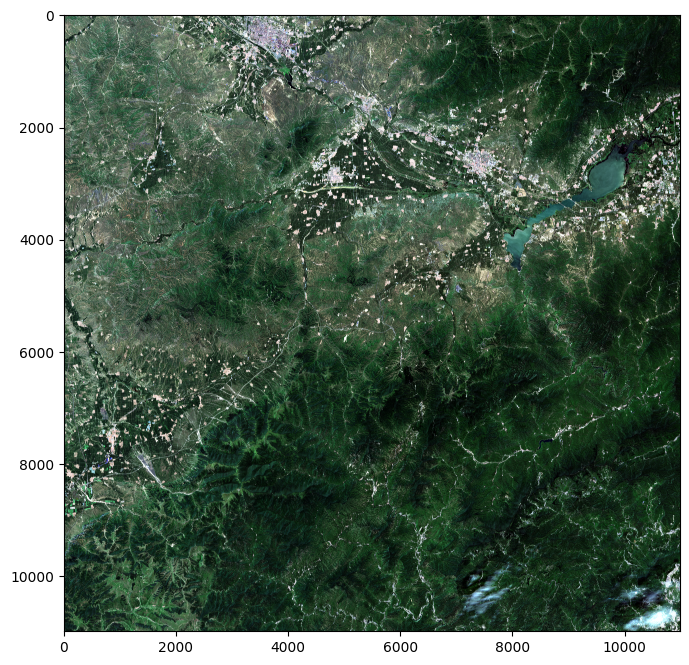

In [144]:
# 显示叠加结果数据信息

#   归一化函数
def stretch(band, lower_percent=2, higher_percent=98): #2和95表示分位数
    band=np.array(band,dtype=np.float32)
    c = np.percentile(band, lower_percent)*1.0
    d = np.percentile(band, higher_percent)*1.0       
    band[band<c] = c
    band[band>d] = d
    out =  (band - c)  / (d - c)  
    return out.astype(np.float32)
def stretch_n(data, n_band=3):  #该操作讲改变原始数据，因此data用.copy，不对原始数据进行更改
    data=np.array(data,dtype=np.float32)
    for k in range(n_band):
            data[:,:,k] = stretch(data[:,:,k])
    return data
def rgb(img_data,iftran=True):
    img_data_3b = img_data[:3,:,:]                  # 取前三个波段 B02,B03,B04
    if iftran:
        img_data_3b = img_data_3b[::-1,:,:]             # 将B02,B03,B04转成B04,B03,B02 (BGR转RGB)
    img_data    = img_data_3b.transpose(1,2,0)     # C,H,W -> H,W,C
    return img_data 

proj, geotrans, img_data, row, column  = read_img(merge_out)
img_data_r=rgb(img_data) #提取3波段改变rgb顺序和数据维度
img_data_rgb_s = np.uint8(stretch_n(img_data_r.copy())*255) # 数据值域缩放至（0~255）

plt.figure(figsize=(8,8))
plt.imshow(Image.fromarray(img_data_rgb_s))
plt.show()


In [179]:
quickimg =save_path+img_identifier+os.sep+img_identifier+"_quickimg.tif"
Write_Tiff(img_data_rgb_s.transpose(2,0,1),ds.GetGeoTransform(),ds.GetProjection(),quickimg)

### 重投影

如果需要对数据进行投影操作，可以利用gdal.warp实现

In [181]:
ds = gdal.Open(quickimg)       # 打开文件
rojectedtmp =save_path+img_identifier+os.sep+img_identifier+"_projected.tif"
ds = gdal.Warp(rojectedtmp, ds, dstSRS='EPSG:4326')    # 有投影的需求可以使用warp命令，epsg可以通过https://epsg.io/查询，这里给出的是wgs84


仿射矩阵信息：(114.63531921298156, 0.00010513256977891853, 0.0, 40.64592849014489, 0.0, -0.00010513256977891853) 投影信息：GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]




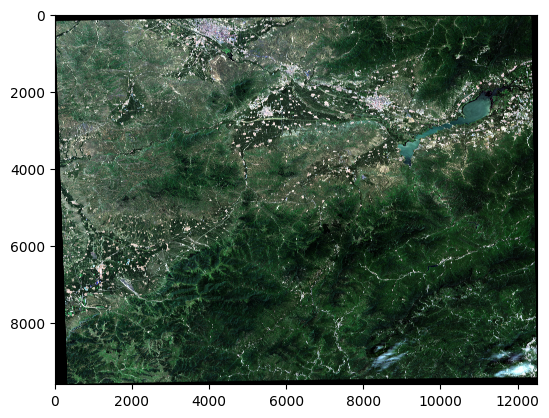

In [182]:
proj, geotrans, img_data, row, column  = read_img(rojectedtmp)

# 显示重投影结果信息
print(f'仿射矩阵信息：{geotrans}',f'投影信息：{proj}')
print("\n")

img_data_ = img_data.transpose(1,2,0)          # C,H,W -> H,W,C
plt.imshow(img_data_)

### 数据裁剪

* 利用rasterio库更容易将shp与影像进行叠加显示
* 利用gdal.warp实现数据裁剪

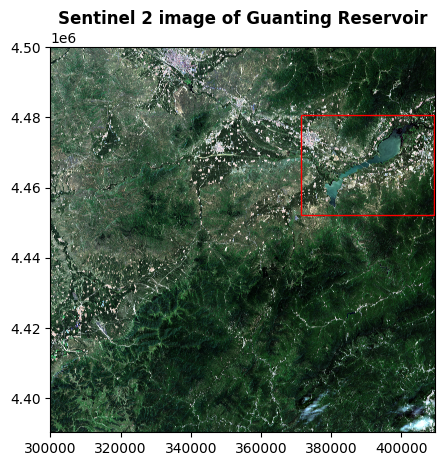

In [184]:
clip_shp = './data/clippolygon.shp'
vector = gpd.read_file(clip_shp)
img=rasterio.open(quickimg)

fig, ax = plt.subplots(figsize=(5,5))
p1 =rasterio.plot.show(img, ax=ax,title='Sentinel 2 image of Guanting Reservoir')
vector.plot(ax=ax,edgecolor='red', linewidth=1,facecolor = "none") #如果shp与raster坐标投影不一致无法同时显示
plt.show()


按矢量轮廓裁剪

In [185]:
# 执行裁剪
clip_output =save_path+img_identifier+os.sep+img_identifier+"_clip.tif"
# 按矢量轮廓裁剪
gdal.Warp(clip_output, merge_out, cutlineDSName = clip_shp, format="GTiff", cropToCutline = True)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x00000169B2690810> >

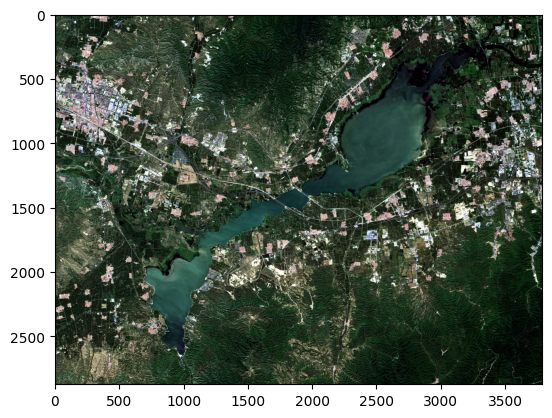

In [186]:
proj, geotrans, img_data, row, column  = read_img(clip_output)
img_data_=rgb(img_data)
plt.imshow(stretch_n(img_data_.copy()))